## Mount the drive and kaggle with Google Colab

In [1]:
# Mount google drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('jessicali9530/celeba-dataset', unzip=True)

# Celebrity Faces Detection Model

- Dataset [Link](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

### Importing necessary libraries

In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import ResNet50, ResNet101V2
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline


## Data Exploration

- We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

- Intialize the basic parameters.

In [23]:
# set variables
images_folder = 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000001.jpg'

TRAINING_SAMPLES = 5000
VALIDATION_SAMPLES = 1500
TEST_SAMPLES = 1500
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 32
NUM_EPOCHS = 10


### Load the attributes of every picture
File: list_attr_celeba.csv

---

### Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [24]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)
print(df_attr.shape)
df_attr.head()

(202599, 40)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [25]:
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   5_o_Clock_Shadow     202599 non-null  int64
 1   Arched_Eyebrows      202599 non-null  int64
 2   Attractive           202599 non-null  int64
 3   Bags_Under_Eyes      202599 non-null  int64
 4   Bald                 202599 non-null  int64
 5   Bangs                202599 non-null  int64
 6   Big_Lips             202599 non-null  int64
 7   Big_Nose             202599 non-null  int64
 8   Black_Hair           202599 non-null  int64
 9   Blond_Hair           202599 non-null  int64
 10  Blurry               202599 non-null  int64
 11  Brown_Hair           202599 non-null  int64
 12  Bushy_Eyebrows       202599 non-null  int64
 13  Chubby               202599 non-null  int64
 14  Double_Chin          202599 non-null  int64
 15  Eyeglasses           202599 non-null  int64

In [26]:
def uniqueValues(feature):
  return df_attr[feature].unique()

for feature in df_attr.columns:
  print(f"{uniqueValues(feature)} <- {feature}")

[0 1] <- 5_o_Clock_Shadow
[1 0] <- Arched_Eyebrows
[1 0] <- Attractive
[0 1] <- Bags_Under_Eyes
[0 1] <- Bald
[0 1] <- Bangs
[0 1] <- Big_Lips
[0 1] <- Big_Nose
[0 1] <- Black_Hair
[0 1] <- Blond_Hair
[0 1] <- Blurry
[1 0] <- Brown_Hair
[0 1] <- Bushy_Eyebrows
[0 1] <- Chubby
[0 1] <- Double_Chin
[0 1] <- Eyeglasses
[0 1] <- Goatee
[0 1] <- Gray_Hair
[1 0] <- Heavy_Makeup
[1 0] <- High_Cheekbones
[0 1] <- Male
[1 0] <- Mouth_Slightly_Open
[0 1] <- Mustache
[0 1] <- Narrow_Eyes
[1 0] <- No_Beard
[0 1] <- Oval_Face
[0 1] <- Pale_Skin
[1 0] <- Pointy_Nose
[0 1] <- Receding_Hairline
[0 1] <- Rosy_Cheeks
[0 1] <- Sideburns
[1 0] <- Smiling
[1 0] <- Straight_Hair
[0 1] <- Wavy_Hair
[1 0] <- Wearing_Earrings
[0 1] <- Wearing_Hat
[1 0] <- Wearing_Lipstick
[0 1] <- Wearing_Necklace
[0 1] <- Wearing_Necktie
[1 0] <- Young


#### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000001.jpg, dtype: int64

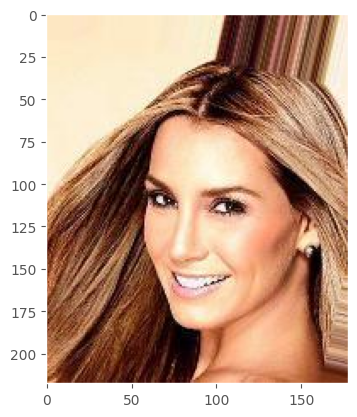

In [27]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

#### Distribution of the Attribute

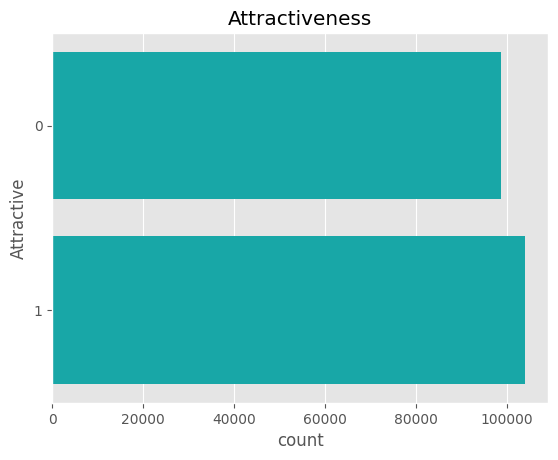

In [28]:
plt.title('Attractiveness')
sns.countplot(y='Attractive', data=df_attr, color="c")
plt.savefig('Attractive_distribution.png')
plt.show()

---
### Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

In [29]:
bbox = pd.read_csv('list_bbox_celeba.csv')
bbox.set_index('image_id', inplace=True)
print(bbox.shape)
bbox.head()

(202599, 4)


,x_1,y_1,width,height
image_id,,,,
000001.jpg,95,71,226,313
000002.jpg,72,94,221,306
000003.jpg,216,59,91,126
000004.jpg,622,257,564,781
000005.jpg,236,109,120,166


In [30]:
bbox.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   x_1     202599 non-null  int64
 1   y_1     202599 non-null  int64
 2   width   202599 non-null  int64
 3   height  202599 non-null  int64
dtypes: int64(4)
memory usage: 7.7+ MB


#### Let's visualize the distribution of the dataset

In [31]:
def graph(feature1, feature2, data):
    plt.figure(figsize=(10, 6))
    plt.hist([data[feature1], data[feature2]], bins=30, color=['blue', 'orange'], alpha=0.7, label=[feature1, feature2])
    plt.title(f'Distribution of {feature1} and {feature2}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{feature1}_and_{feature2}.png')
    plt.show()

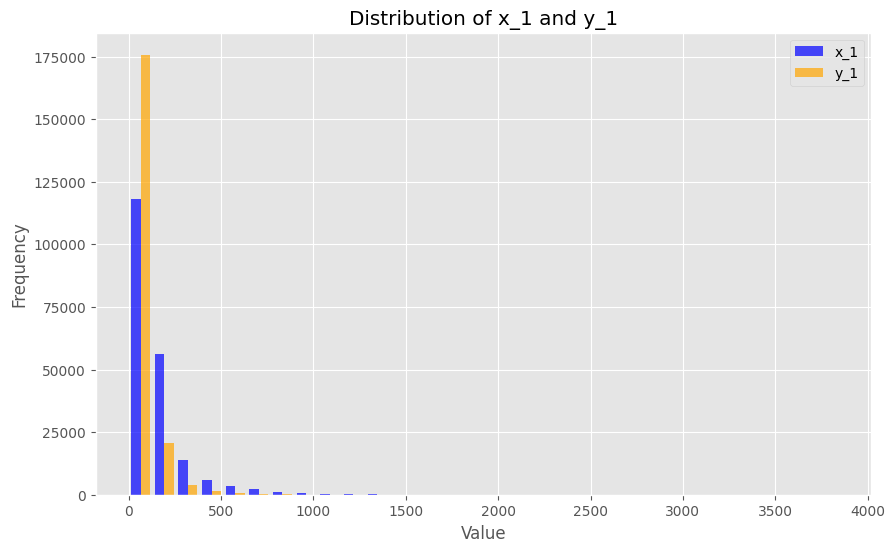

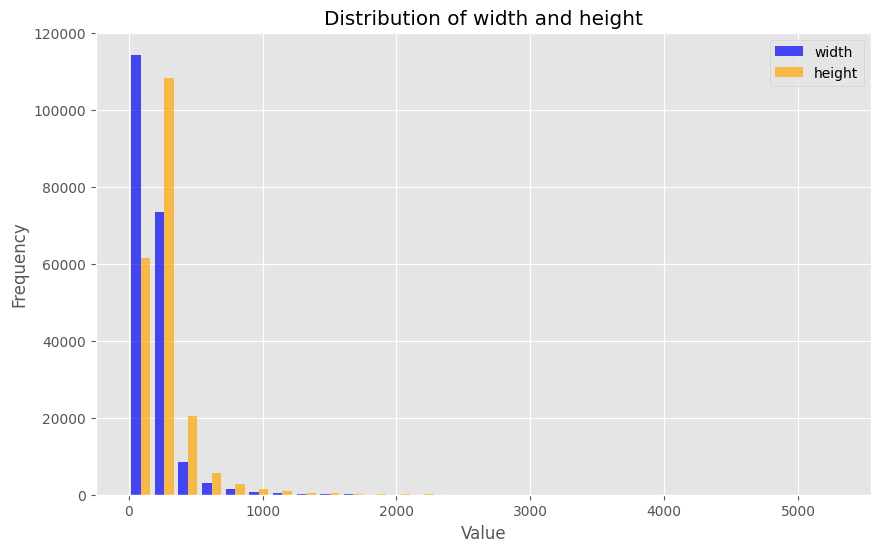

In [32]:
for i in range(0, len(bbox.columns), 2):
    graph(bbox.columns[i], bbox.columns[i+1], bbox)

In [33]:
bbox.describe()

,x_1,y_1,width,height
count,202599.000000,202599.000000,202599.000000,202599.000000
mean,156.764564,84.335505,194.754061,268.922329
std,164.518135,76.067284,141.770066,195.664936
min,1.000000,0.000000,0.000000,0.000000
25%,69.000000,44.000000,120.000000,166.000000
50%,110.000000,68.000000,164.000000,227.000000
75%,181.000000,98.000000,221.000000,306.000000
max,3840.000000,1858.000000,3827.000000,5299.000000


---
### Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth

In [34]:
landmarks = pd.read_csv('list_landmarks_align_celeba.csv')
landmarks.set_index('image_id', inplace=True)
print(landmarks.shape)
landmarks.head()

(202599, 10)


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,69,109,106,113,77,142,73,152,108,154
000002.jpg,69,110,107,112,81,135,70,151,108,153
000003.jpg,76,112,104,106,108,128,74,156,98,158
000004.jpg,72,113,108,108,101,138,71,155,101,151
000005.jpg,66,114,112,112,86,119,71,147,104,150


In [35]:
landmarks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   lefteye_x     202599 non-null  int64
 1   lefteye_y     202599 non-null  int64
 2   righteye_x    202599 non-null  int64
 3   righteye_y    202599 non-null  int64
 4   nose_x        202599 non-null  int64
 5   nose_y        202599 non-null  int64
 6   leftmouth_x   202599 non-null  int64
 7   leftmouth_y   202599 non-null  int64
 8   rightmouth_x  202599 non-null  int64
 9   rightmouth_y  202599 non-null  int64
dtypes: int64(10)
memory usage: 17.0+ MB


#### Let's visualize the distribution of `landmarks` dataset

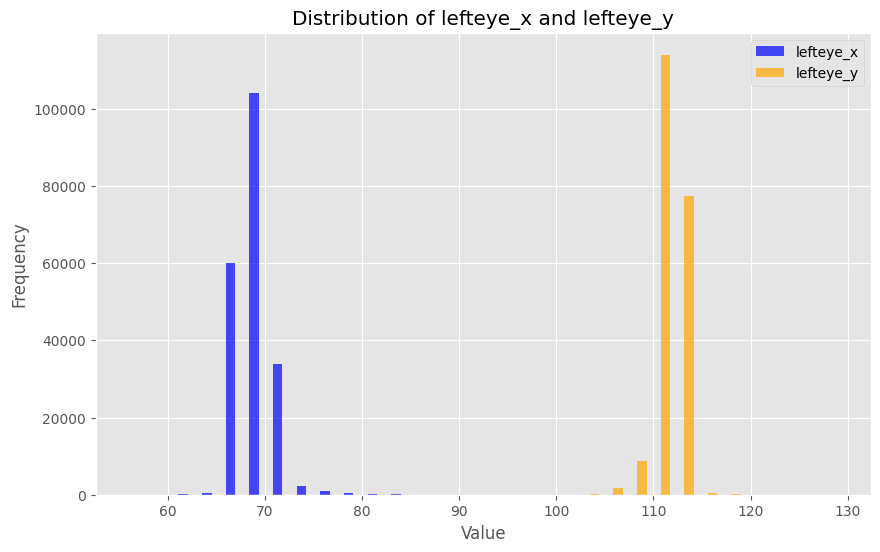

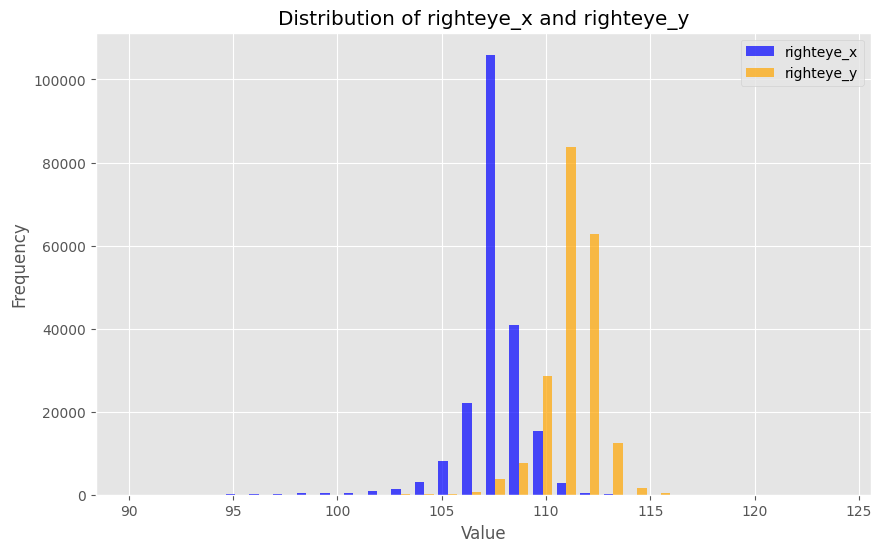

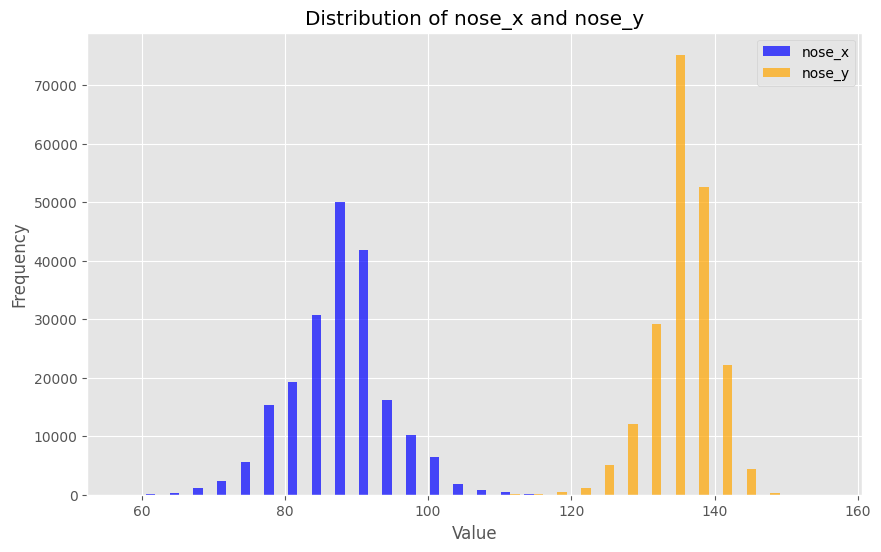

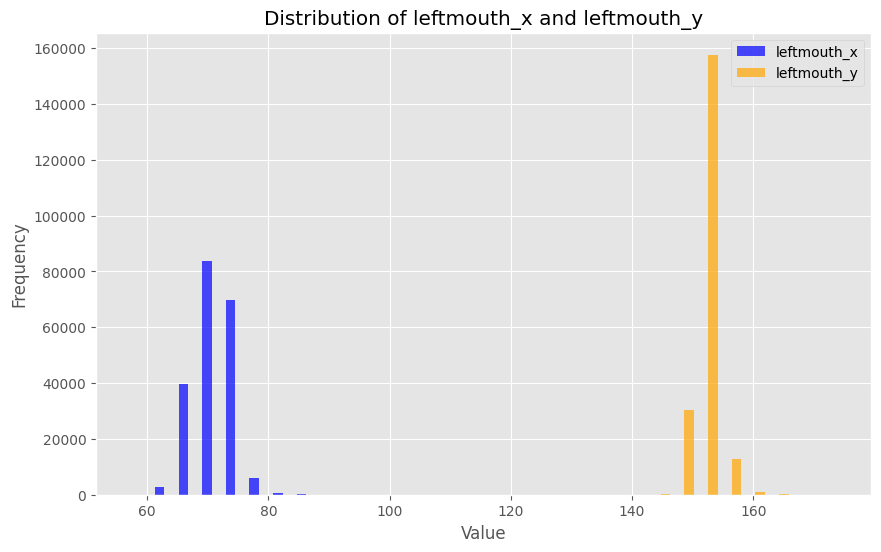

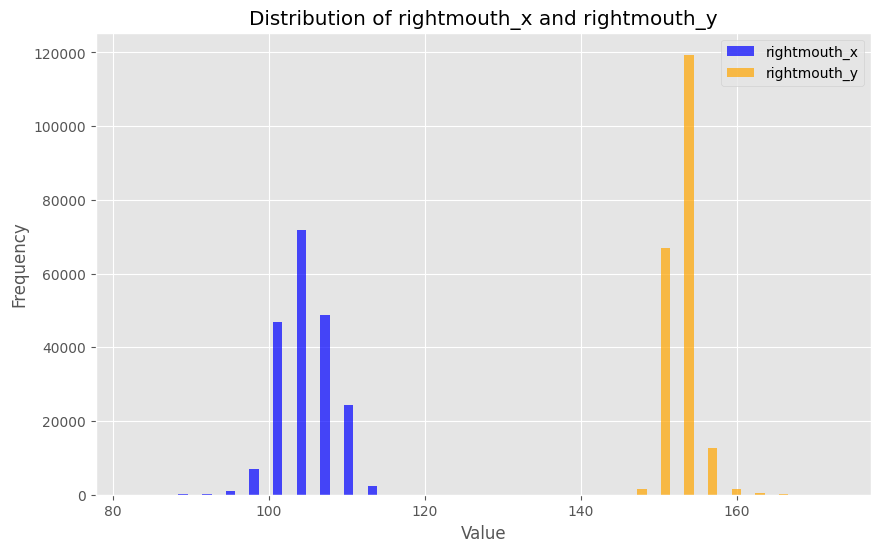

In [36]:
for i in range(0, len(landmarks.columns), 2):
    graph(landmarks.columns[i], landmarks.columns[i+1], landmarks)

---
## Split Dataset into Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is:
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing

The partition is in file <b>list_eval_partition.csv</b>

Due time execution, by now we will be using a reduced number of images:

* Training 20000 images
* Validation 5000 images
* Test 5000 Images


In [37]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [38]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [39]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Attractive'], how='inner')
df_par_attr.head()

,partition,Attractive
image_id,,
000001.jpg,0,1
000002.jpg,0,0
000003.jpg,0,0
000004.jpg,0,1
000005.jpg,0,1


### Generate Partitions (Train, Validation, Test)

In [40]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_, df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = to_categorical(df_[attr],2)
    else:
        x_ = []
        y_ = []
        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Pre-processing Images: Data Augmentation

### Let's start with an example: Data Augmentation

This is how an image will look like after data augmentation (based in the giving parameters below).

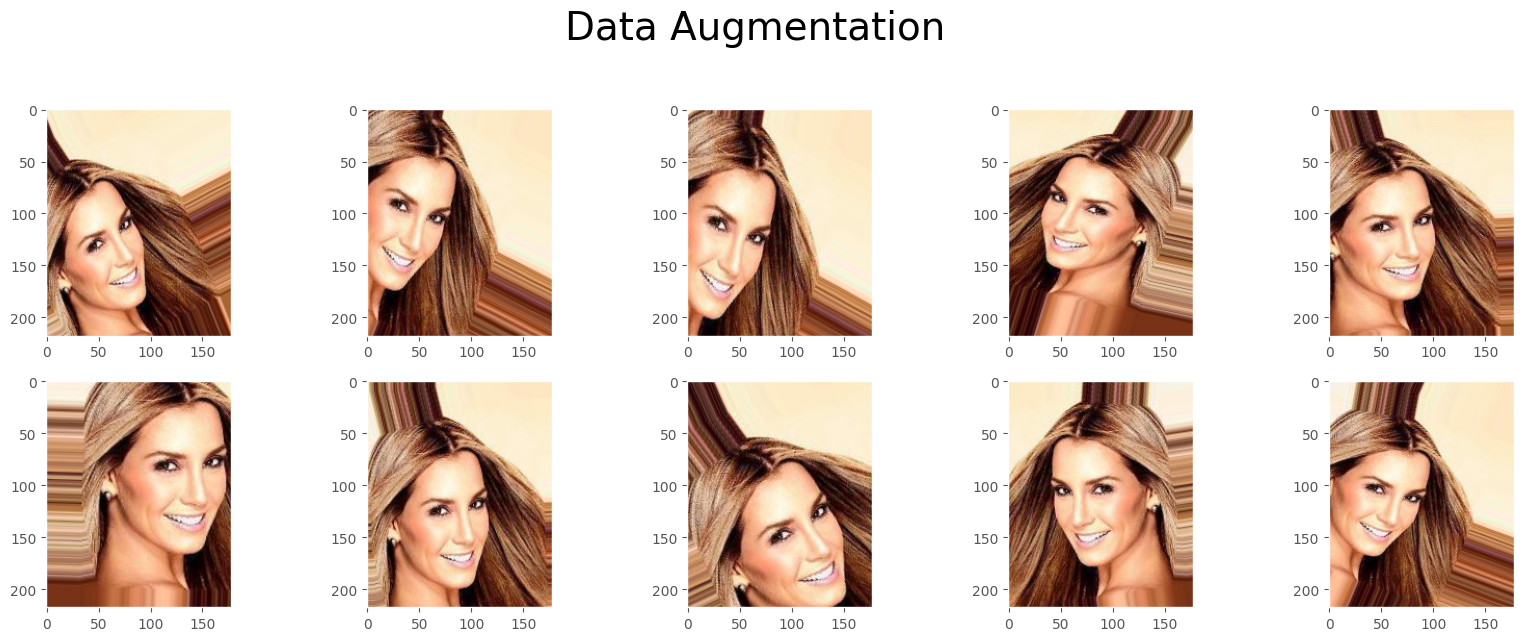

In [41]:
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))

    if i == 9:
        break
    i += 1

plt.savefig('data_augmentation.png')
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

### Build Data Generators

In [42]:
x_train, y_train = generate_df(0, 'Attractive', TRAINING_SAMPLES)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [43]:
x_valid, y_valid = generate_df(1, 'Attractive', VALIDATION_SAMPLES)

With the data generator created and data for validation, we are ready to start modeling.

## Build the Model

### Inception V3 Model

In [44]:
kaggle.api.dataset_download_files('crawford/inceptionv3', unzip=True)

In [45]:
inc_model = InceptionV3(weights='/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Number of layers:", len(inc_model.layers))

Number of layers: 311


In [46]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [47]:
model = Model(inputs=inc_model.input, outputs=predictions)

for layer in model.layers[:52]:
    layer.trainable = False

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 108, 88, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 108, 88, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 108, 88, 32)          0         ['batch_normalization[0][0

- Fit the Model

In [48]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.attractive.hdf5', verbose=1, save_best_only=True)

In [49]:
hist = model.fit_generator(train_generator,
                            validation_data = (x_valid, y_valid),
                            steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE,
                            epochs= NUM_EPOCHS,
                            callbacks=[checkpointer],
                            verbose=1
                           )

<ipython-input-49-83398f706d4b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator,


Epoch 1/10
157/156 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.6660
Epoch 1: val_loss improved from inf to 0.92918, saving model to weights.best.inc.attractive.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/156 [==============================] - 92s 420ms/step - loss: 0.6181 - accuracy: 0.6660 - val_loss: 0.9292 - val_accuracy: 0.5033
Epoch 2/10
157/156 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.7480
Epoch 2: val_loss improved from 0.92918 to 0.87662, saving model to weights.best.inc.attractive.hdf5
156/156 [==============================] - 57s 361ms/step - loss: 0.5262 - accuracy: 0.7480 - val_loss: 0.8766 - val_accuracy: 0.5067
Epoch 3/10
157/156 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7682
Epoch 3: val_loss improved from 0.87662 to 0.76393, saving model to weights.best.inc.attractive.hdf5
156/156 [==============================] - 57s 362ms/step - loss: 0.4890 - accuracy: 0.7682 - val_loss: 0.7639 - val_accuracy: 0.5020
Epoch 4/10
157/156 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.7766
Epoch 4: val_loss did not improve from 0.76393
156/156 [==============================] - 56s 356ms/step - l

#### The Inception V3 model after training got an accuracy over the validation data of 69.60%.
---

### ResNet 50 Model

In [50]:
resnet_model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Number of layers:", len(resnet_model.layers))

94765736/94765736 [==============================] - 1s 0us/step
Number of layers: 175


In [51]:
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [52]:
model_resnet = Model(inputs=resnet_model.input, outputs=predictions)

for layer in model_resnet.layers[:52]:
    layer.trainable = False

model_resnet.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 224, 184, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 109, 89, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 109, 89, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [53]:
resnet_checkpointer = ModelCheckpoint(filepath='weights.best.resnet.attractiveresnet.hdf5', verbose=1, save_best_only=True)

In [54]:
resnet_hist = model_resnet.fit_generator(train_generator,
                                   validation_data=(x_valid, y_valid),
                                   steps_per_epoch=TRAINING_SAMPLES/BATCH_SIZE,
                                   epochs=NUM_EPOCHS,
                                   callbacks=[resnet_checkpointer],
                                   verbose=1)

<ipython-input-54-0b2b85b4fcab>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_hist = model_resnet.fit_generator(train_generator,


Epoch 1/10
157/156 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.4934
Epoch 1: val_loss improved from inf to 0.69441, saving model to weights.best.resnet.attractiveresnet.hdf5
156/156 [==============================] - 86s 442ms/step - loss: 0.7274 - accuracy: 0.4934 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 2/10
157/156 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69441 to 0.69323, saving model to weights.best.resnet.attractiveresnet.hdf5
156/156 [==============================] - 64s 406ms/step - loss: 0.6995 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 3/10
157/156 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.4964
Epoch 3: val_loss did not improve from 0.69323
156/156 [==============================] - 63s 400ms/step - loss: 0.6960 - accuracy: 0.4964 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 4/10
157/156 [===========================

#### The ResNet50 model after training got an accuracy over the validation data of 50.20%.
---

### ResNet101 V2 Model

In [55]:
base_model = ResNet101V2(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Number of layers:", len(base_model.layers))

171317808/171317808 [==============================] - 2s 0us/step
Number of layers: 377


In [56]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [57]:
model_resnetv2 = Model(inputs=base_model.input, outputs=predictions)

for layer in model_resnetv2.layers[:75]:
    layer.trainable = False

model_resnetv2.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

model_resnetv2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 224, 184, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 109, 89, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 111, 91, 64)          0         ['conv1_conv[0][0]']          
                                                                                            

In [58]:
resnetv2_checkpointer = ModelCheckpoint(filepath='weights.best.resnet.attractiveresnetv2.hdf5', verbose=1, save_best_only=True)

In [59]:
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_valid)

In [60]:
resnetv2_hist = model_resnetv2.fit_generator(train_generator,
                                   validation_data=(x_valid, y_valid),
                                   steps_per_epoch=TRAINING_SAMPLES/BATCH_SIZE,
                                   epochs=NUM_EPOCHS,
                                   callbacks=[resnetv2_checkpointer],
                                   verbose=1)

<ipython-input-60-3757a05730c6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnetv2_hist = model_resnetv2.fit_generator(train_generator,


Epoch 1/10
157/156 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.5234
Epoch 1: val_loss improved from inf to 0.70876, saving model to weights.best.resnet.attractiveresnetv2.hdf5
156/156 [==============================] - 118s 562ms/step - loss: 0.7014 - accuracy: 0.5234 - val_loss: 0.7088 - val_accuracy: 0.5000
Epoch 2/10
157/156 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.6456
Epoch 2: val_loss did not improve from 0.70876
156/156 [==============================] - 81s 518ms/step - loss: 0.6389 - accuracy: 0.6456 - val_loss: 0.7614 - val_accuracy: 0.5000
Epoch 3/10
157/156 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.6932
Epoch 3: val_loss improved from 0.70876 to 0.69806, saving model to weights.best.resnet.attractiveresnetv2.hdf5
156/156 [==============================] - 84s 537ms/step - loss: 0.5933 - accuracy: 0.6932 - val_loss: 0.6981 - val_accuracy: 0.5100
Epoch 4/10
157/156 [======================

#### The ResNet101 V2 model after training got an accuracy over the validation data of 62.13%.
---

## Graphical Visualization of result of traning of different models

### Inception V3 Model

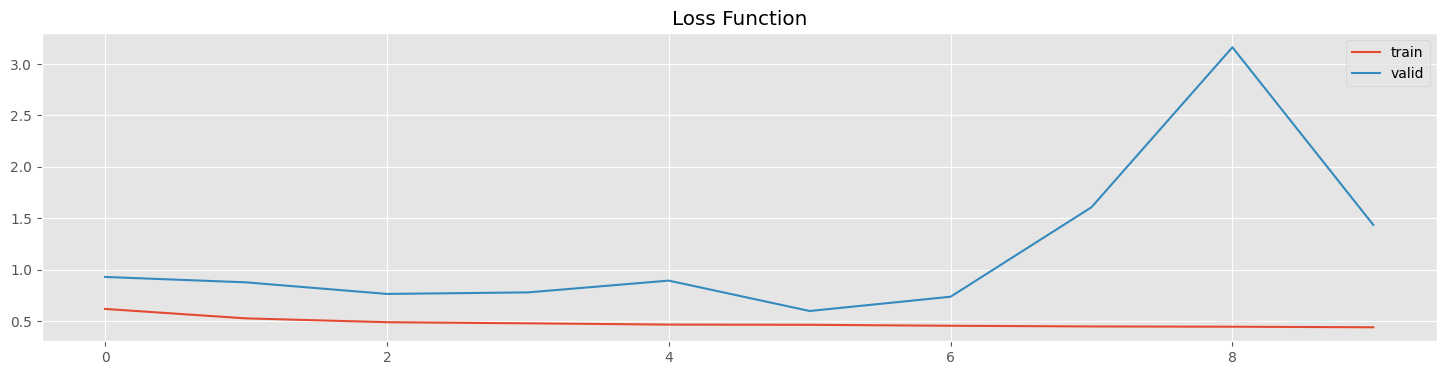

In [61]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('loss_function_inception.png')
plt.show()

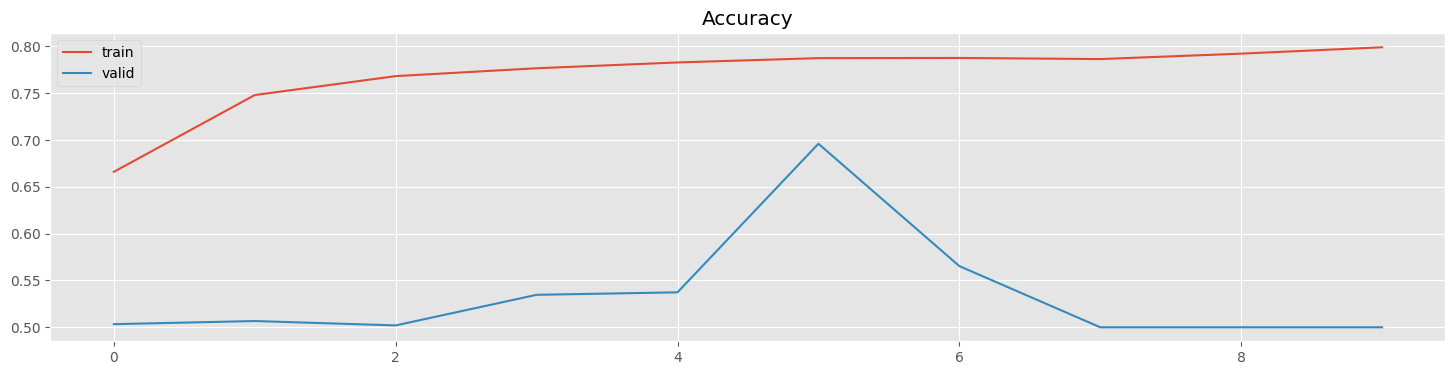

In [62]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy_inception.png')
plt.show()

### ResNet50 Model

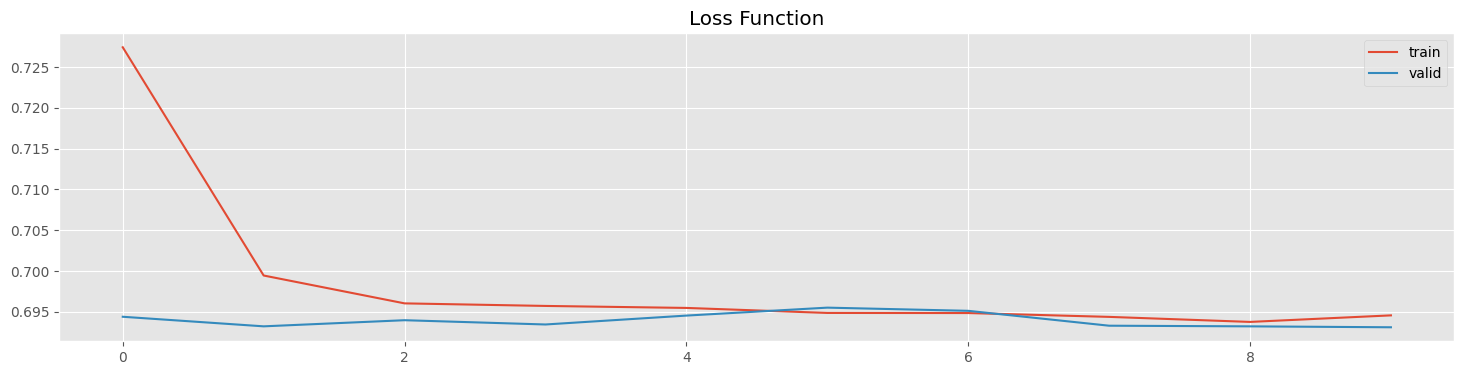

In [63]:
plt.figure(figsize=(18, 4))
plt.plot(resnet_hist.history['loss'], label = 'train')
plt.plot(resnet_hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('loss_function_resnet50.png')
plt.show()

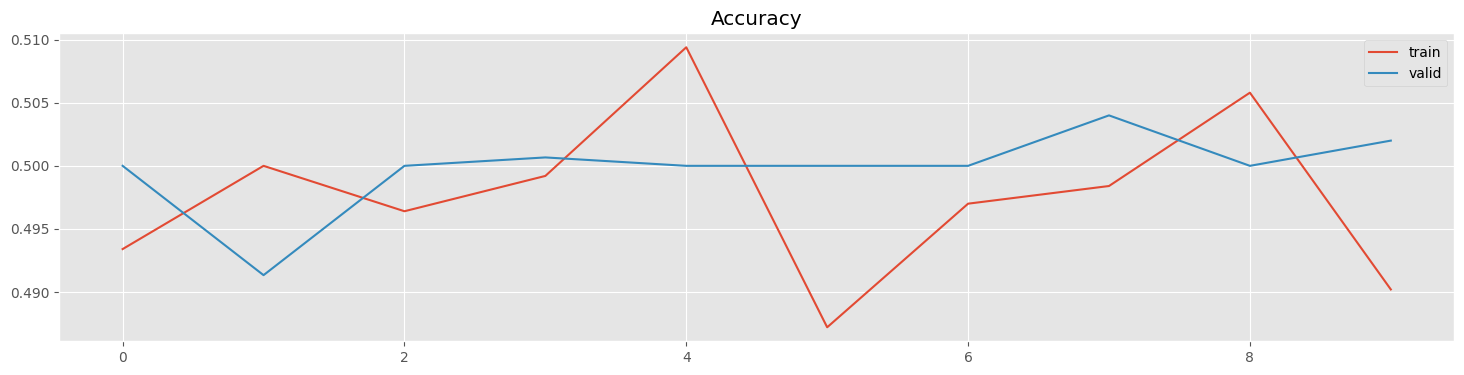

In [64]:
plt.figure(figsize=(18, 4))
plt.plot(resnet_hist.history['accuracy'], label = 'train')
plt.plot(resnet_hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy_resnet50.png')
plt.show()

### ResNet101V2 Model

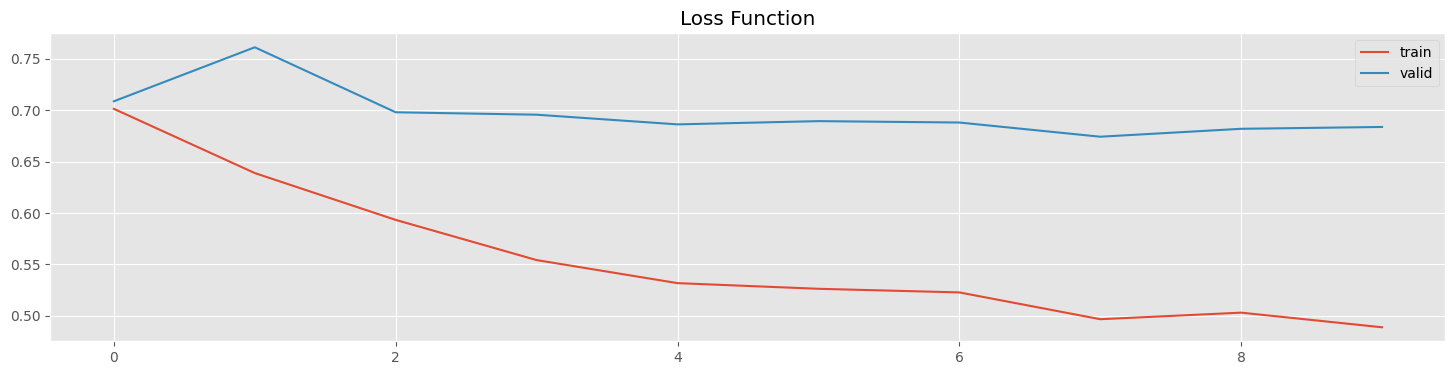

In [65]:
plt.figure(figsize=(18, 4))
plt.plot(resnetv2_hist.history['loss'], label = 'train')
plt.plot(resnetv2_hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('loss_function_resnet101v2.png')
plt.show()

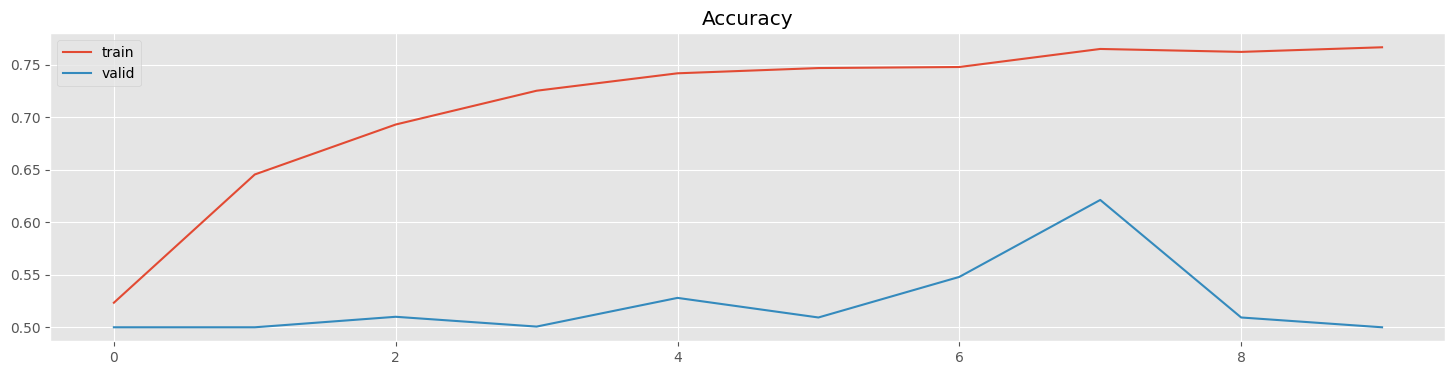

In [66]:
plt.figure(figsize=(18, 4))
plt.plot(resnetv2_hist.history['accuracy'], label = 'train')
plt.plot(resnetv2_hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy_resnet101v2.png')
plt.show()

## Load the best fit Model for testing.

In [70]:
model.load_weights('weights.best.inc.attractive.hdf5')

In [71]:
x_test, y_test = generate_df(2, 'Attractive', TEST_SAMPLES)

model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

1/1 [==============================] - 0s 37ms/step


In [72]:
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 68.8000%
f1_score: 0.7114673242909988


In [73]:
# dictionary to name the prediction
attractive_target = {0: 'Not Attractive', 1: 'Attractive'}

def img_to_display(filename):
  i = Image.open(filename)
  i.thumbnail((200, 200), Image.LANCZOS)

  with BytesIO() as buffer:
      i.save(buffer, 'jpeg')
      return base64.b64encode(buffer.getvalue()).decode()

def display_result(filename, prediction, target):
  '''
  Display the results in HTML
  '''
  attractive = 'Attractive'

  if prediction[1] <= 0.5:
      attractive = 'Not Attractive'

  display_html = '''
  <div style="overflow: auto;  border: 2px solid #D8D8D8;
      padding: 5px; width: 420px;" >
      <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
      <div style="padding: 10px 0px 0px 20px; overflow: auto;">
          <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
          <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
          <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
          <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
      </div>
  </div>
  '''.format(img_to_display(filename),
              attractive,
              "{0:.2f}%".format(round(max(prediction)*100,2)),
              attractive_target[target],
              filename.split('/')[-1]
            )

  display(HTML(display_html))

In [76]:
def attractive_prediction(filename):
  '''
  predict the attractive

  input:
      filename: str of the file name

  return:
      array of the prob of the targets.
  '''

  im = cv2.imread(filename)
  im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
  im = np.expand_dims(im, axis =0)

  # prediction
  result = model.predict(im)
  prediction = np.argmax(result)

  return result

1/1 [==============================] - 0s 25ms/step



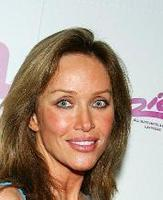

1/1 [==============================] - 0s 28ms/step



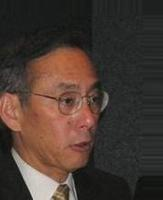

1/1 [==============================] - 0s 26ms/step



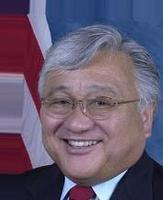

1/1 [==============================] - 0s 27ms/step



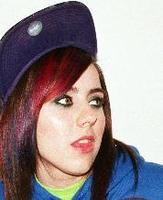

1/1 [==============================] - 0s 26ms/step



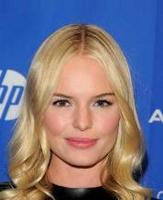

1/1 [==============================] - 0s 27ms/step



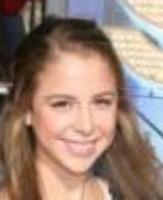

1/1 [==============================] - 0s 25ms/step



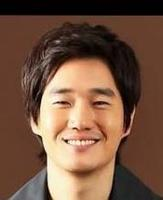

1/1 [==============================] - 0s 25ms/step



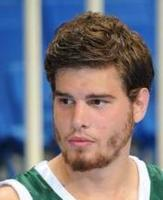

In [79]:
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
  result = attractive_prediction(images_folder + index)
  display_result(images_folder + index, result[0], target['Attractive'])


# Model Completed!